``lux.ai - Curso de Fotografia Computacional - Aprendizado de Máquina e Profundo``

## Classificação de lesões de pele com deep learning

Neste projeto irei construir um sistema para estimação de lesões na pele, indicando a ausência ou presença de sinais malignos que podem ser considerados câncer.

Utilizarei como base, o dataset [ISIC16](https://challenge.isic-archive.com/landing/2016/) que corresponde ao desafio de classificação do ISIC em 2016.

O desafio contém 3 tarefas: classificação benigno/maligno, segmentação do sinal e segmentação de atributos.

Abaixo podemos visualizar alguns exemplos correspondentes a estas tasks:

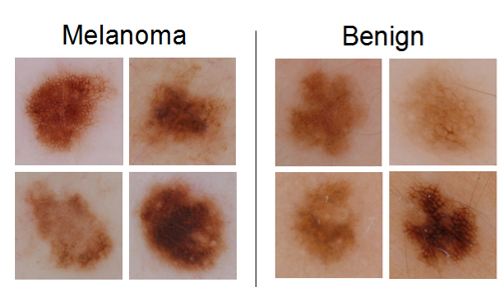

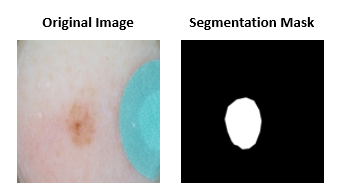

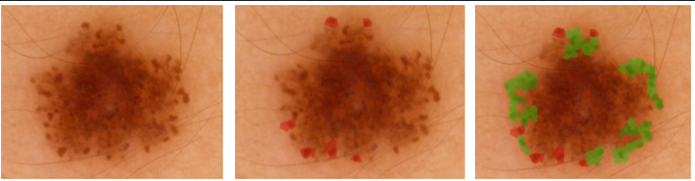

A tarefa será propor um sistema que realiza a classificação da lesão, obtendo a melhor taxa possível.

- Para os testes, devemos máximizar o nosso **Recall**, ou seja, queremos o menor número de falsos negativos possível (pessoas que tem câncer e rotulamos como benigno)

- Além disso, precisamos obter um sistema que alcança uma acurácia (>.70)

- Devemos combinar diferentes arquiteturas com a finalidade de melhorar nosso resultado (combinando segmentação com classificação, realizando augmentations, ajustando otimizadores, e avaliando os resultados intermédiarios)

- Seu modelo deve poder rodar em CPU, e não levar mais que 10s para realizar a inferência (o treinamento não precisar ser em CPU, apenas a inferência)

- Vamos utilizar um sistema de monitoramento para avaliar a performance do nosso treinamento.

- Acurácia final: o modelo será avaliado em um conjunto de teste externo (não incluido no dataset da atividade)

Utilizando tudo que foi aprendido na disciplina, você pode escolher a arquitetura que mais se adequa ao problema, para atender aos requisitos mencionados. (Criar novos modelos, utilizar modelos pré-treinados, customizar modelos existentes)

O modelo não precisa se restringir as arquiteturas utilizadas anteriormente, o PyTorch contém diversos modelos, que utilizam padrões de uso similares aos modelos já testados. (Alguns podem ser mais leves, e obter resultados equiparáveis aos modelos já testados)

Ajuste os dados para gerar os loaders e partições para treinamento e avaliação do modelo.




Guia de uso weights & biases: https://colab.research.google.com/github/wandb/examples/blob/master/colabs/intro/Intro_to_Weights_&_Biases.ipynb

In [ ]:
!rm -rf luxai_fotografia_computacional_rscs/

!git clone https://github.com/TIC-13/luxai_fotografia_computacional_rscs.git

!mv luxai_fotografia_computacional_rscs/isic16 ./isic16

'''
Content/
  isic16/
    isic16-segmentation-resized/
    [Image_ID].jpg
    [Image_ID]_Segmentation.png
  isic_2016_metadata.csv
'''

Cloning into 'luxai_fotografia_computacional_rscs'...
remote: Enumerating objects: 1812, done.
remote: Counting objects: 100% (1812/1812), done.
remote: Compressing objects: 100% (1809/1809), done.
remote: Total 1812 (delta 3), reused 1808 (delta 2), pack-reused 0
Receiving objects: 100% (1812/1812), 20.12 MiB | 34.23 MiB/s, done.
Resolving deltas: 100% (3/3), done.


'\nContent/\n  isic16/\n    isic16-segmentation-resized/\n    [Image_ID].jpg\n    [Image_ID]_Segmentation.png\n  isic_2016_metadata.csv\n'

In [ ]:
import pandas as pd

isic16_df = pd.read_csv("./isic16/isic_2016_metadata.csv")

# Lidando com valores ausentes
isic16_df.fillna("", inplace=True)

isic16_df.head(5)

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,diagnosis,diagnosis_confirm_type,family_hx_mm,image_type,melanocytic,personal_hx_mm,sex
0,ISIC_0000000,Anonymous,CC-0,55.0,anterior torso,benign,,nevus,,,dermoscopic,True,,female
1,ISIC_0000001,Anonymous,CC-0,30.0,anterior torso,benign,,nevus,,,dermoscopic,True,,female
2,ISIC_0000002,Anonymous,CC-0,60.0,upper extremity,malignant,,melanoma,histopathology,,dermoscopic,True,,female
3,ISIC_0000004,Anonymous,CC-0,80.0,posterior torso,malignant,,melanoma,histopathology,,dermoscopic,True,,male
4,ISIC_0000006,Anonymous,CC-0,25.0,posterior torso,benign,,nevus,,,dermoscopic,True,,female


### Importando bibliotecas

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

### Codifocando variáveis categóricas

In [ ]:
# One-hot encoding para as variáveis categóricas 'anatom_site_general' e 'sex'
isic16_df = pd.get_dummies(isic16_df, columns=['anatom_site_general', 'sex'])

### Divisão dos dados

In [ ]:
# Separando os dados de treino, validação e teste
train_df, test_df = train_test_split(isic16_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

### Criação da Classe SkinLesionDataset

In [ ]:
class SkinLesionDataset(Dataset):
  def __init__(self, dataframe, image_dir, transform=None):
    self.dataframe = dataframe
    self.image_dir = image_dir
    self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    img_name = self.dataframe.iloc[idx, 0] + ".jpg"
    img_path = os.path.join(self.image_dir, img_name)
    image = Image.open(img_path)
    label = 1 if self.dataframe.iloc[idx, 5] == "malignant" else 0  # Convertendo para binário: 0 para benigno e 1 para maligno

    if self.transform:
      image = self.transform(image)

    return image, label

### Transformações de imagem

In [ ]:
# Definindo transformações para aumentação de dados
train_transform = transforms.Compose([
  transforms.RandomResizedCrop(224),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### Criando instâncias

In [ ]:
# Criando instâncias dos conjuntos de dados
train_dataset = SkinLesionDataset(train_df, "./isic16/isic16-segmentation-resized/", transform=transform)
val_dataset = SkinLesionDataset(val_df, "./isic16/isic16-segmentation-resized/", transform=transform)
test_dataset = SkinLesionDataset(test_df, "./isic16/isic16-segmentation-resized/", transform=transform)

### Criando DataLoader

In [ ]:
batch_size = 32

train_dataset = SkinLesionDataset(dataframe=train_df, image_dir="./isic16/isic16-segmentation-resized/", transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Criação do SkinLesionClassifier

In [ ]:
class SkinLesionClassifier(nn.Module):
  def __init__(self, num_classes=2):
    super(SkinLesionClassifier, self).__init__()

    self.resnet = models.resnet18(pretrained=True)

    for param in self.resnet.parameters():
      param.requires_grad = False

    self.resnet.fc = nn.Sequential(
        nn.Dropout(0.5),  # Adicionar dropout
        nn.Linear(self.resnet.fc.in_features, num_classes)
    )

  def forward(self, x):
    x = self.resnet(x)
    return x

model = SkinLesionClassifier()

### Criando a função de perda e o otimizador

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Treinamento

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Definindo número de épocas e inicializando variáveis
num_epochs = 10
best_val_accuracy = 0.0
best_model_weights = None

# Loop de treinamento
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  correct_predictions = 0
  total_predictions = 0

  for images, labels in train_loader:
    # Transferindo os dados para o dispositivo de execução
    images, labels = images.to(device), labels.to(device)

    # Zerando os gradientes
    optimizer.zero_grad()

    # Forward pass
    outputs = model(images)

    # Calculando a perda
    loss = criterion(outputs, labels)

    # Backward pass e atualização dos pesos
    loss.backward()
    optimizer.step()

    # Calculando estatísticas de treinamento
    running_loss += loss.item() * images.size(0)
    _, predicted = torch.max(outputs, 1)
    correct_predictions += (predicted == labels).sum().item()
    total_predictions += labels.size(0)

  # Calculando estatísticas de treinamento
  epoch_loss = running_loss / len(train_loader.dataset)
  train_accuracy = correct_predictions / total_predictions

  # Modo de avaliação
  model.eval()
  val_running_loss = 0.0
  val_correct_predictions = 0
  val_total_predictions = 0

  with torch.no_grad():
    for images, labels in val_loader:
      # Transferindo os dados para o dispositivo de execução
      images, labels = images.to(device), labels.to(device)

      # Forward pass
      outputs = model(images)

      # Calculando a perda
      loss = criterion(outputs, labels)

      # Calculando estatísticas de validação
      val_running_loss += loss.item() * images.size(0)
      _, predicted = torch.max(outputs, 1)
      val_correct_predictions += (predicted == labels).sum().item()
      val_total_predictions += labels.size(0)

  # Calculando estatísticas de validação
  val_epoch_loss = val_running_loss / len(val_loader.dataset)
  val_accuracy = val_correct_predictions / val_total_predictions

  # Atualizando melhor modelo baseado na acurácia de validação
  if val_accuracy > best_val_accuracy:
    best_val_accuracy = val_accuracy
    best_model_weights = model.state_dict()

  # Imprimindo estatísticas de cada época
  print(f"Epoch [{epoch+1}/{num_epochs}]\n"
        f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}\n"
        f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n")

Epoch [1/10]
Train Loss: 0.1005, Train Accuracy: 0.9528
Val Loss: 0.0003, Val Accuracy: 1.0000

Epoch [2/10]
Train Loss: 0.0002, Train Accuracy: 1.0000
Val Loss: 0.0001, Val Accuracy: 1.0000

Epoch [3/10]
Train Loss: 0.0002, Train Accuracy: 1.0000
Val Loss: 0.0001, Val Accuracy: 1.0000

Epoch [4/10]
Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0001, Val Accuracy: 1.0000

Epoch [5/10]
Train Loss: 0.0002, Train Accuracy: 1.0000
Val Loss: 0.0001, Val Accuracy: 1.0000

Epoch [6/10]
Train Loss: 0.0002, Train Accuracy: 1.0000
Val Loss: 0.0001, Val Accuracy: 1.0000

Epoch [7/10]
Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0001, Val Accuracy: 1.0000

Epoch [8/10]
Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000

Epoch [9/10]
Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000

Epoch [10/10]
Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000



In [ ]:
model.load_state_dict(best_model_weights)

<All keys matched successfully>

### Avaliando o modelo

In [ ]:
# Função para avaliar o modelo usando os dados de teste e calcular métricas de desempenho
def evaluate_model(model, test_loader):
  model.eval()  # Mudar para o modo de avaliação

  all_predictions = []
  all_targets = []

  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)

      # Fazer previsões
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      # Adicionar previsões e rótulos verdadeiros às listas
      all_predictions.extend(predicted.cpu().numpy())
      all_targets.extend(labels.cpu().numpy())

  # Calcular métricas de desempenho
  accuracy = accuracy_score(all_targets, all_predictions)
  precision = precision_score(all_targets, all_predictions)
  recall = recall_score(all_targets, all_predictions)
  f1 = f1_score(all_targets, all_predictions)

  print(f"Acurácia: {accuracy:.4f}")
  print(f"Precisão: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-score: {f1:.4f}")

In [ ]:
evaluate_model(model, test_loader)

Acurácia: 1.0000
Precisão: 0.0000
Recall: 0.0000
F1-score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
